In [1]:
import sys
sys.path.append("../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    NBEATSModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk

import ray
from ray import tune
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"
ray.init(num_gpus=1)



{'node_ip_address': '130.149.248.55',
 'raylet_ip_address': '130.149.248.55',
 'redis_address': '130.149.248.55:6379',
 'object_store_address': '/tmp/ray/session_2022-03-11_14-31-55_010238_228801/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-11_14-31-55_010238_228801/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-11_14-31-55_010238_228801',
 'metrics_export_port': 63543,
 'gcs_address': '130.149.248.55:44891',
 'node_id': '48cf698efb0bb485e937479f135c5211bc2125b703356960d9a0cf54'}

In [2]:
dl =  DatasetLoader( 'data/cpu_memory_rate.csv', "Time", ["cpu_rate","memory_rate"],
                    resample_freq="1min", augment=False, shift_df_datetime="2022-03-05 00:00:00")
train, val, _ = dl.get_train_val_test(train_size=6/7,val_test_ratio=1.0)

In [7]:
train.append((dl.augment_specific_times(train, [slice("2022-03-10 00:00:00", None)])))
train = dl.augment_series(train)
train

<TimeSeries (DataArray) (Time: 112320, component: 2, sample: 1)>
array([[[0.00458279],
        [0.15805006]],

       [[0.00207118],
        [0.15857497]],

       [[0.00361465],
        [0.15895024]],

       ...,

       [[0.02274294],
        [0.14065265]],

       [[0.02735765],
        [0.14106902]],

       [[0.02544275],
        [0.14121928]]])
Coordinates:
  * Time       (Time) datetime64[ns] 2022-03-01 ... 2022-05-17T23:59:00
  * component  (component) object 'cpu_rate' 'memory_rate'
Dimensions without coordinates: sample

In [ ]:
ss = dl.augment_specific_times(train, [slice("2022-02-23 10:37:00", "2022-02-24 10:37:00")])


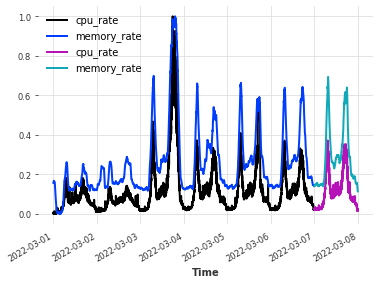

In [9]:
train.plot()
val.plot()

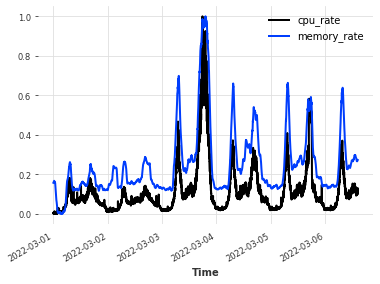

In [3]:
train.plot()

In [7]:
def training_function(config):
     
#     if config["input_chunk_length"] < config["output_chunk_length"]:
#         return
    
    quantiles = [0.1, 0.5, 0.9]
    input_chunk_length = 30
    output_chunk_length = 5
    model = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        num_stacks=config["num_stacks"],
        num_blocks=config["num_blocks"],
        num_layers=config["num_layers"],
        layer_widths=config["layer_widths"],
        batch_size=64,
        n_epochs=11, 
        random_state=0,
        log_tensorboard=True,
        add_encoders={
        'datetime_attribute': {'past': ['dayofweek']},
        'custom': {'past': [lambda idx: (idx.minute) + (idx.hour*60)]},
        "position": {"past": ["relative"]},
        'transformer': Scaler()
        },
        likelihood=QuantileRegression(
            quantiles=quantiles
        ), 
        work_dir=".",
        torch_device_str='cuda:0'
    )
        
    model.fit(train, val_series=val)
    
    pred = model.predict(n=input_chunk_length, num_samples=100)
    rr = 0.0
    for rho in quantiles:
        rr += rho_risk(val[:input_chunk_length], pred, rho=rho)
    rr = rr / len(quantiles)
    
    tune.report(mean_loss=rr)
    


In [8]:
max_concurrent_trials = 4
analysis = tune.run(
    training_function,
    max_concurrent_trials=max_concurrent_trials,
    resources_per_trial={'cpu': 8.0/max_concurrent_trials, 'gpu': 1.0/max_concurrent_trials},
    local_dir="logs/nbeats_sblw",
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
    config={
        "num_stacks": tune.grid_search([30, 50]),
        "num_blocks": tune.grid_search([1, 4]),
        "num_layers": tune.grid_search([4, 8]),
        "layer_widths": tune.grid_search([256, 512]),
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



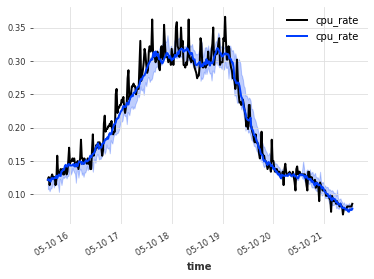

In [14]:
pred_len = 360
pred = model.predict(series=test[:-pred_len], n=pred_len, num_samples=100)
for i in range(pred.n_components):
    test[-pred_len:].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9)
    plt.show()